In [38]:
import numpy as np
from skimage.transform import resize
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Conv2D, ConvLSTM2D, TimeDistributed
from sklearn.externals import joblib
import pylidc as pl

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score, precision_score
from matplotlib import pyplot as plt
%matplotlib inline

In [14]:
image_size = (256, 256)
num_slices = 50

In [40]:
unet = load_model('unet.hdf5')
lstm = load_model('unet_lstm.hdf5')
lstm_new = load_model('unet_lstm_new.hdf5')
lstm_bw = load_model('unet_lstm_bw.hdf5')

In [16]:
scans = pl.query(pl.Scan)
n = scans.count()

In [17]:
test = joblib.load('test_set.p')
train = list(set(range(n)) - set(test))

In [18]:
def get_annotated_slices(ann):
    zs = ann.bbox()[-1]
    return zs.start, zs.stop

In [19]:
def get_data_unet(i):
    scan = scans[i]
    images = scan.load_all_dicom_images(verbose=False)
    n = len(images)
    X = np.array([resize(im.pixel_array, image_size, mode='constant') for im in images])
    X = np.expand_dims(X, axis=-1)
    y = np.zeros((512, 512, n))
    for ann in scan.annotations:
        b = ann.bbox()
        y[b] = np.logical_or(y[b], ann.boolean_mask())
    y = np.rollaxis(y, 2, 0)
    y = resize(y, (n, *image_size), mode='constant')
    y = np.expand_dims(y, axis=-1)
    nodule_zs = set.union(set(), *(set(range(*get_annotated_slices(ann))) for ann in scan.annotations))
    while True:
        start = np.random.randint(n - num_slices)
        if any(start <= z < start + num_slices for z in nodule_zs) or not nodule_zs:
            break
    X = X[start:start + num_slices]
    y = y[start:start + num_slices]
    return unet.predict(X, batch_size=1)[None], y[None]

In [92]:
def evaluate(i):
    while True:
        try:
            X, y = get_data_unet(i)
            if y.sum() > 0:
                break
        except OSError:
            pass
    
    preds_unet = X
    fpr_unet, tpr_unet, _ = roc_curve(np.rint(y).flatten(), preds_unet.flatten())
    
    rc_unet = recall_score(np.rint(y).flatten(), np.rint(preds_unet).flatten())
    pc_unet = precision_score(np.rint(y).flatten(), np.rint(preds_unet).flatten())

    preds_lstm = lstm.predict(preds_unet)
    fpr_lstm, tpr_lstm, _ = roc_curve(np.rint(y).flatten(), preds_lstm.flatten())
    rc_lstm = recall_score(np.rint(y).flatten(), np.rint(preds_lstm).flatten())
    pc_lstm = precision_score(np.rint(y).flatten(), np.rint(preds_lstm).flatten())

    preds_lstm_bw = lstm_bw.predict(preds_unet)
    fpr_lstm_bw, tpr_lstm_bw, _ = roc_curve(np.rint(y).flatten(), preds_lstm_bw.flatten())
    rc_lstm_bw = recall_score(np.rint(y).flatten(), np.rint(preds_lstm_bw).flatten())
    pc_lstm_bw = precision_score(np.rint(y).flatten(), np.rint(preds_lstm_bw).flatten())
    
    # print stuff
    print('AUC, precision, recall for patient num', i)
    print('Unet:',auc(fpr_unet, tpr_unet), pc_unet, rc_unet)
    print('LSTM:',auc(fpr_lstm, tpr_lstm), pc_lstm, rc_lstm)
    print('LSTM bw:',auc(fpr_lstm_bw, tpr_lstm_bw), pc_lstm_bw, rc_lstm_bw)
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(fpr_unet, tpr_unet, label='UNet AUC = '+str(np.round(auc(fpr_unet, tpr_unet),2)))
    ax.set_title("Patient "+str(i)+" ROC")
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.plot(fpr_lstm, tpr_lstm, label='RNN AUC = '+str(np.round(auc(fpr_lstm, tpr_lstm), 2)))
    ax.plot(fpr_lstm_bw, tpr_lstm_bw, label='RNN (for-bac) AUC = '+str(np.round(auc(fpr_lstm_bw, tpr_lstm_bw), 2)))
    plt.legend(bbox_to_anchor=(1.65, 1))
    plt.show()
    
    fsize = 5
    n_slices = 10
    fig, ax = plt.subplots(n_slices, 3, figsize=(3 * fsize, 10 * fsize))
    for x in range(ax.shape[0]):
        z = np.random.randint(X.shape[1])
        for i, m in enumerate((y, preds_unet, preds_lstm)):
            a = ax[x, i]
            #data = a.imshow(m[0, z, :, :, 0], vmin=0, vmax=1, cmap='Greys')
            data = a.imshow(m[0, z, :, :, 0])
            fig.colorbar(data, ax=a)
    plt.show()


In [66]:
preds_thres

array([0.00161943, 0.00100574, 0.00132712, ..., 0.00187272, 0.00130107,
       0.00106442], dtype=float32)

In [28]:
# for unknown test patient
print(auc(fpr_unet, tpr_unet))
print(auc(fpr_lstm, tpr_lstm))
print(auc(fpr_lstm_new, tpr_lstm_new))

0.6969914202414558
0.8912131502403386
0.8837230095393956


Text(0.5,1,'RNN (multi-layer) ROC')

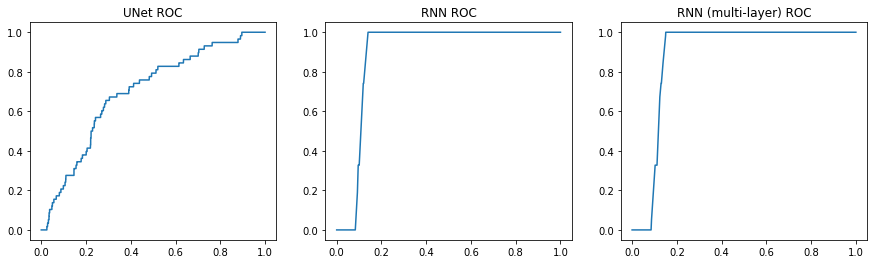

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(fpr_unet, tpr_unet)
ax[0].set_title('UNet ROC')
ax[1].plot(fpr_lstm, tpr_lstm)
ax[1].set_title('RNN ROC')
ax[2].plot(fpr_lstm_new, tpr_lstm_new)
ax[2].set_title('RNN (multi-layer) ROC')
#plt.savefig('roc_curves.jpg', dpi=300)

0.9996454761333549
0.5765523097318147
0.540518652003637


Text(0.5,0,'FPR')

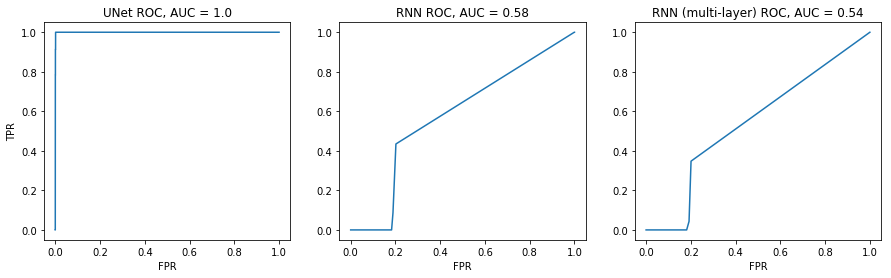

In [36]:
# for test patient 574
print(auc(fpr_unet, tpr_unet))
print(auc(fpr_lstm, tpr_lstm))
print(auc(fpr_lstm_new, tpr_lstm_new))

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(fpr_unet, tpr_unet)
ax[0].set_title('UNet ROC, AUC = '+str(np.round(auc(fpr_unet, tpr_unet),2)))
ax[0].set_ylabel('TPR')
ax[0].set_xlabel('FPR')
ax[1].plot(fpr_lstm, tpr_lstm)
ax[1].set_title('RNN ROC, AUC = '+str(np.round(auc(fpr_lstm, tpr_lstm), 2)))
ax[1].set_xlabel('FPR')
ax[2].plot(fpr_lstm_new, tpr_lstm_new)
ax[2].set_title('RNN (multi-layer) ROC, AUC = '+str(np.round(auc(fpr_lstm_new, tpr_lstm_new), 2)))
ax[2].set_xlabel('FPR')

#plt.savefig('roc_curves.jpg', dpi=300)

0.8791041983986191
0.39974050879563183
0.39942648262922603


Text(0.5,0,'FPR')

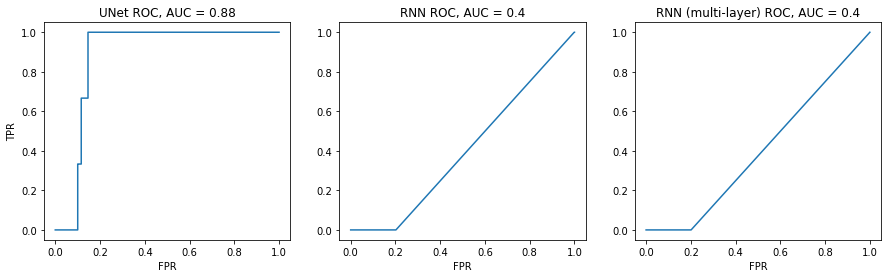

In [39]:
# for test patient 572
print(auc(fpr_unet, tpr_unet))
print(auc(fpr_lstm, tpr_lstm))
print(auc(fpr_lstm_new, tpr_lstm_new))

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(fpr_unet, tpr_unet)
ax[0].set_title('UNet ROC, AUC = '+str(np.round(auc(fpr_unet, tpr_unet),2)))
ax[0].set_ylabel('TPR')
ax[0].set_xlabel('FPR')
ax[1].plot(fpr_lstm, tpr_lstm)
ax[1].set_title('RNN ROC, AUC = '+str(np.round(auc(fpr_lstm, tpr_lstm), 2)))
ax[1].set_xlabel('FPR')
ax[2].plot(fpr_lstm_new, tpr_lstm_new)
ax[2].set_title('RNN (multi-layer) ROC, AUC = '+str(np.round(auc(fpr_lstm_new, tpr_lstm_new), 2)))
ax[2].set_xlabel('FPR')

#plt.savefig('roc_curves.jpg', dpi=300)

Text(0.5,1,'RNN (multi-layer) ROC')

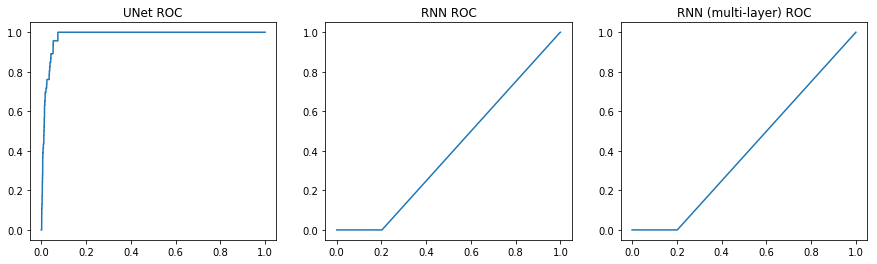

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(fpr_unet, tpr_unet)
ax[0].set_title('UNet ROC')
ax[1].plot(fpr_lstm, tpr_lstm)
ax[1].set_title('RNN ROC')
ax[2].plot(fpr_lstm_new, tpr_lstm_new)
ax[2].set_title('RNN (multi-layer) ROC')
#plt.savefig('roc_curves.jpg', dpi=300)

AUC, precision, recall for patient num 904
Unet: 0.9810064950013762 0.0 0.0
LSTM: 0.3996598462991119 0.0 0.0
LSTM bw: 0.7775094717940774 0.0 0.0


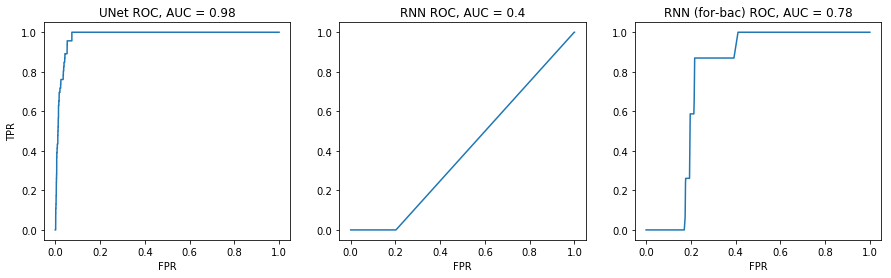

In [57]:
evaluate(904)

/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


AUC, precision, recall for patient num 5
Unet: 0.8229906350063328 0.0 0.0
LSTM: 0.39973534071448846 0.0 0.0
LSTM bw: 0.5281606925654314 0.0 0.0


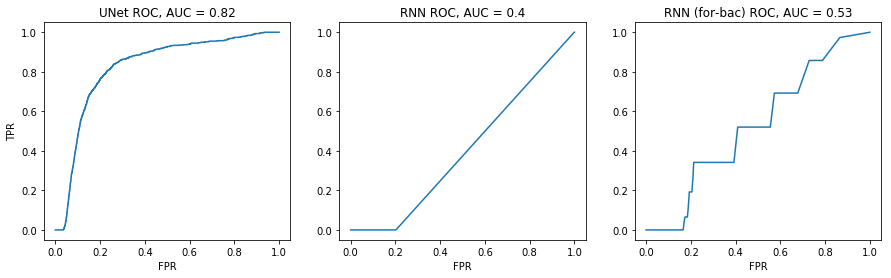

In [60]:
evaluate(5)

/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


AUC, precision, recall for patient num 900
Unet: 0.5529410234327888 0.0 0.0
LSTM: 0.39972323405689003 0.0 0.0
LSTM bw: 0.06716723999443358 0.0 0.0


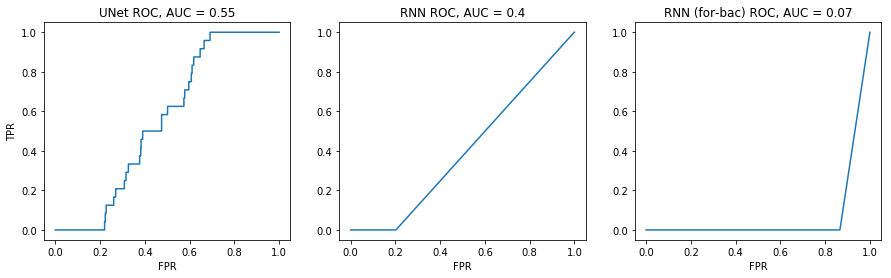

In [74]:
evaluate(900)

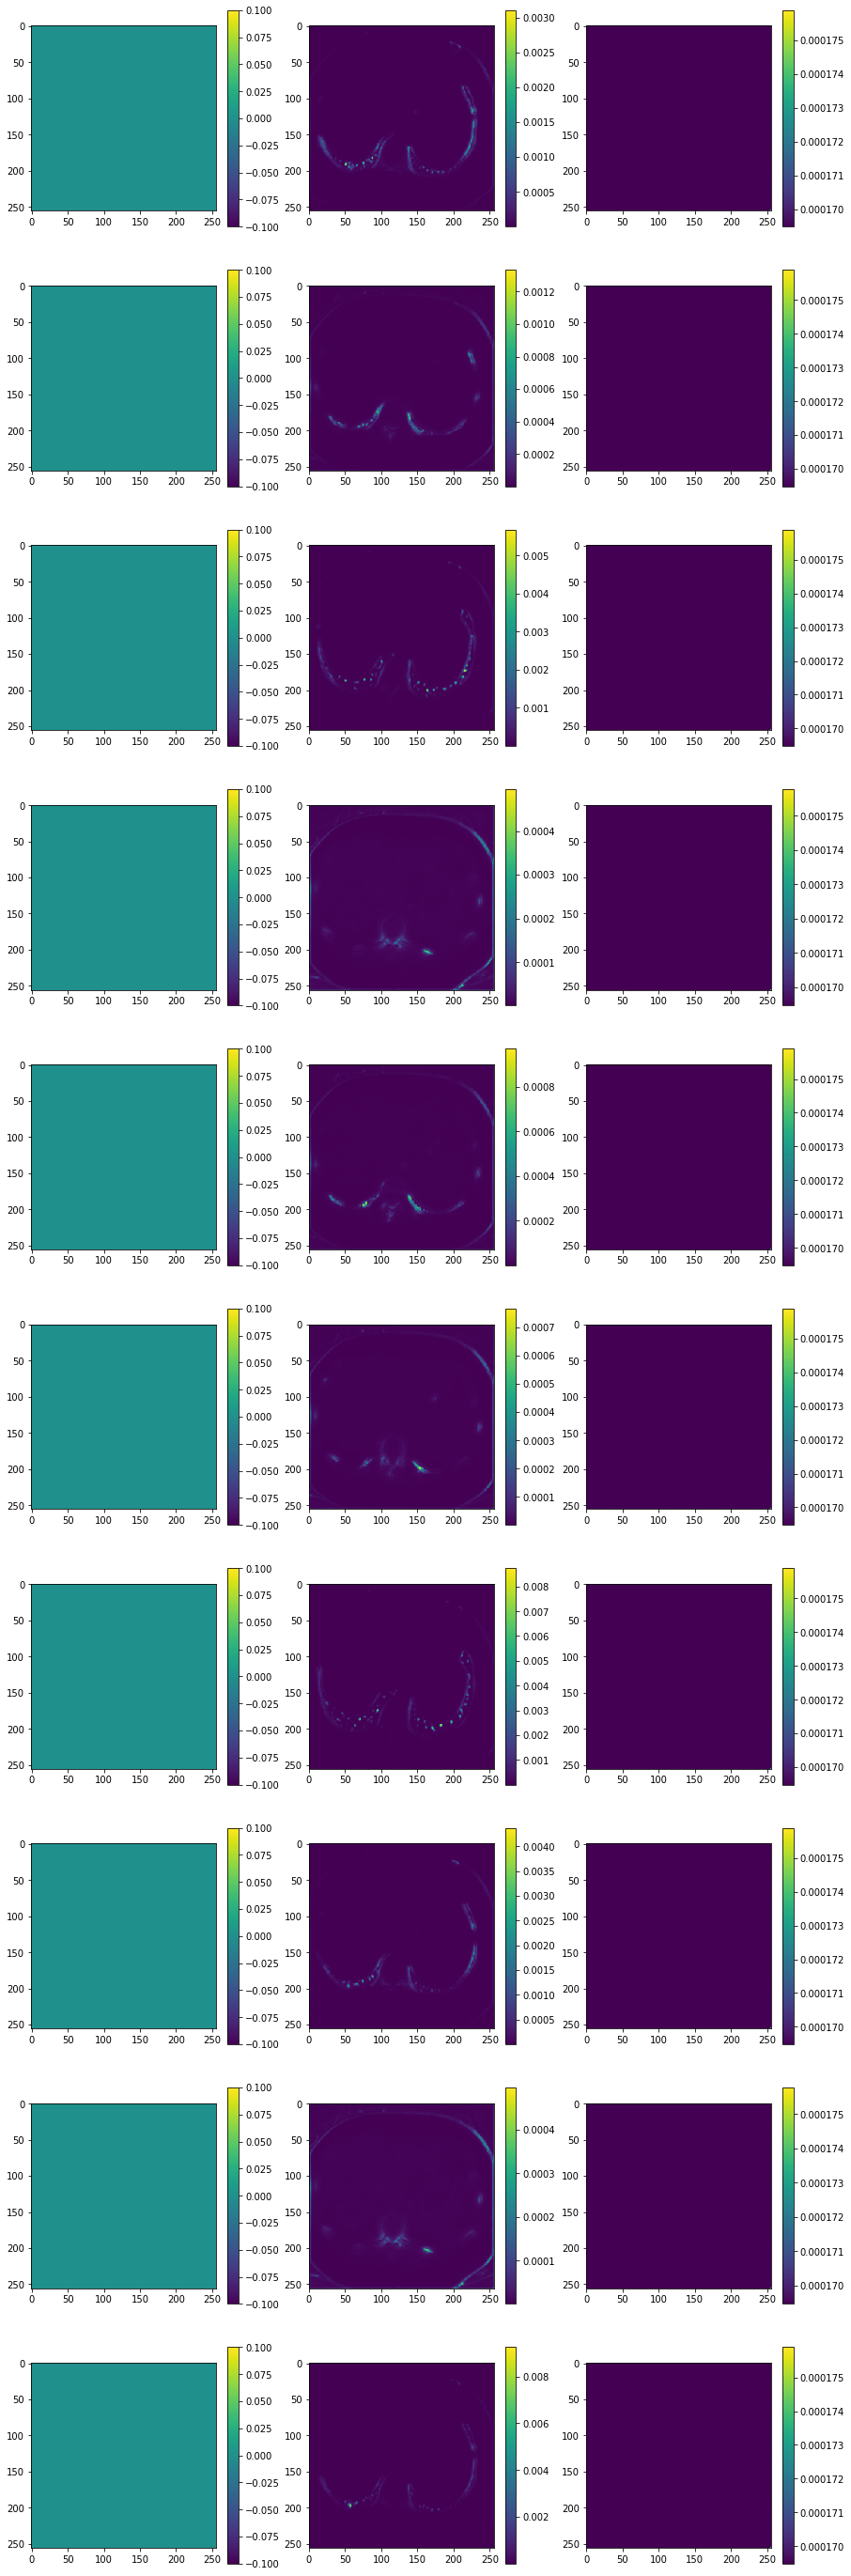

In [77]:
fsize = 5
n_slices = 10
fig, ax = plt.subplots(n_slices, 3, figsize=(3 * fsize, 10 * fsize))
for x in range(ax.shape[0]):
    z = np.random.randint(X.shape[1])
    for i, m in enumerate((y, preds_unet, preds_lstm)):
        a = ax[x, i]
        #data = a.imshow(m[0, z, :, :, 0], vmin=0, vmax=1, cmap='Greys')
        data = a.imshow(m[0, z, :, :, 0])
        fig.colorbar(data, ax=a)

/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


AUC, precision, recall for patient num 88
Unet: 0.8928986783922941 0.0 0.0
LSTM: 0.39971727402598556 0.0 0.0
LSTM bw: 0.2033728508234791 0.0 0.0


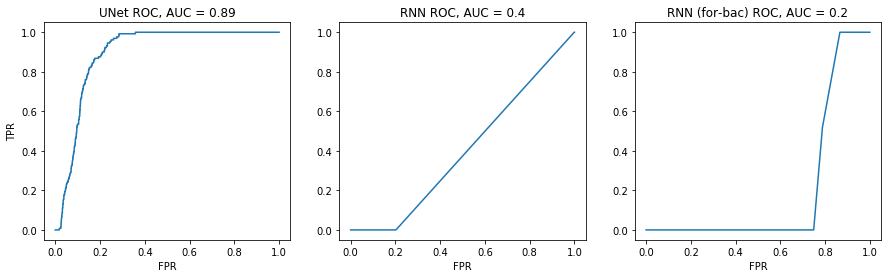

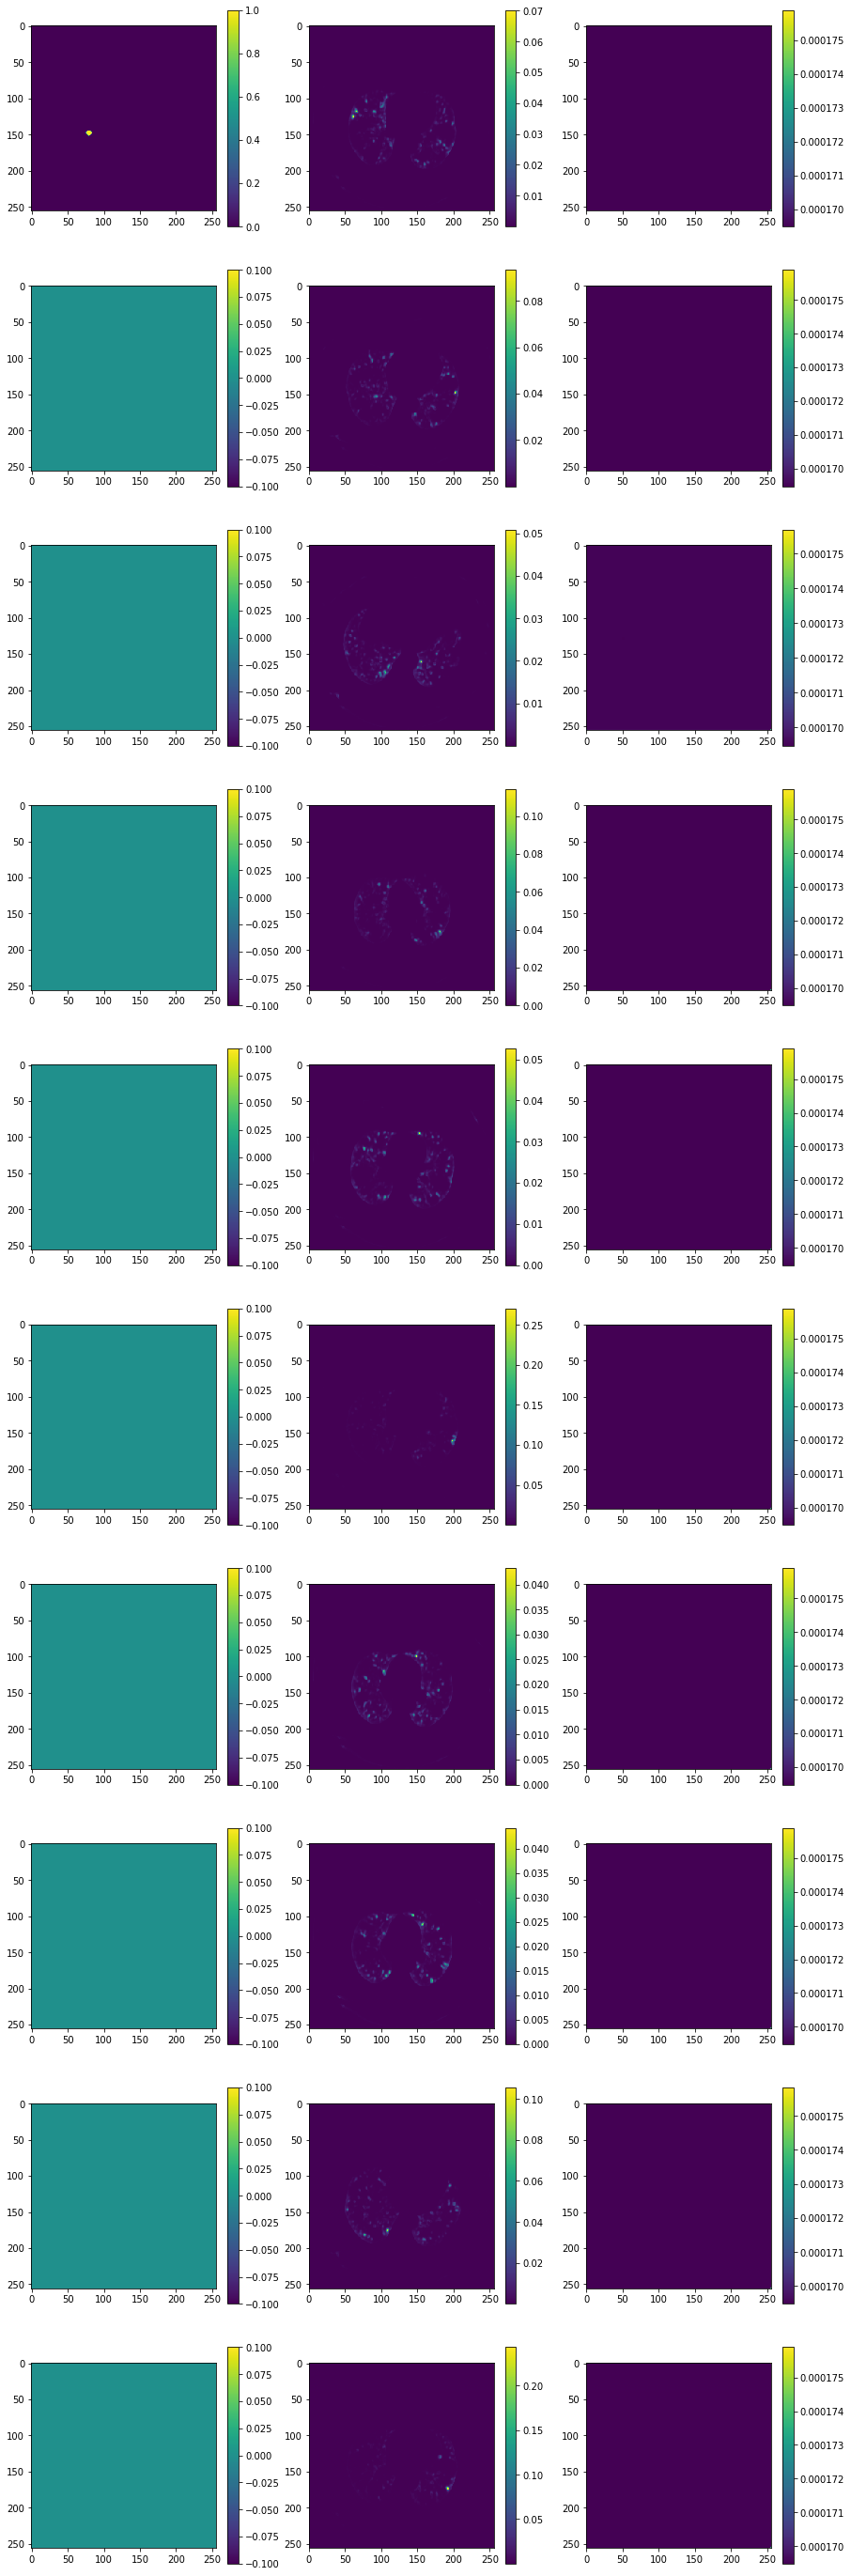

In [80]:
evaluate(88)

/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


AUC, precision, recall for patient num 617
Unet: 0.9806978976274756 0.0 0.0
LSTM: 0.41787021920091477 0.0 0.0
LSTM bw: 0.5391001425821281 0.0 0.0


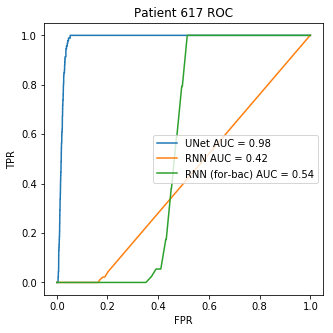

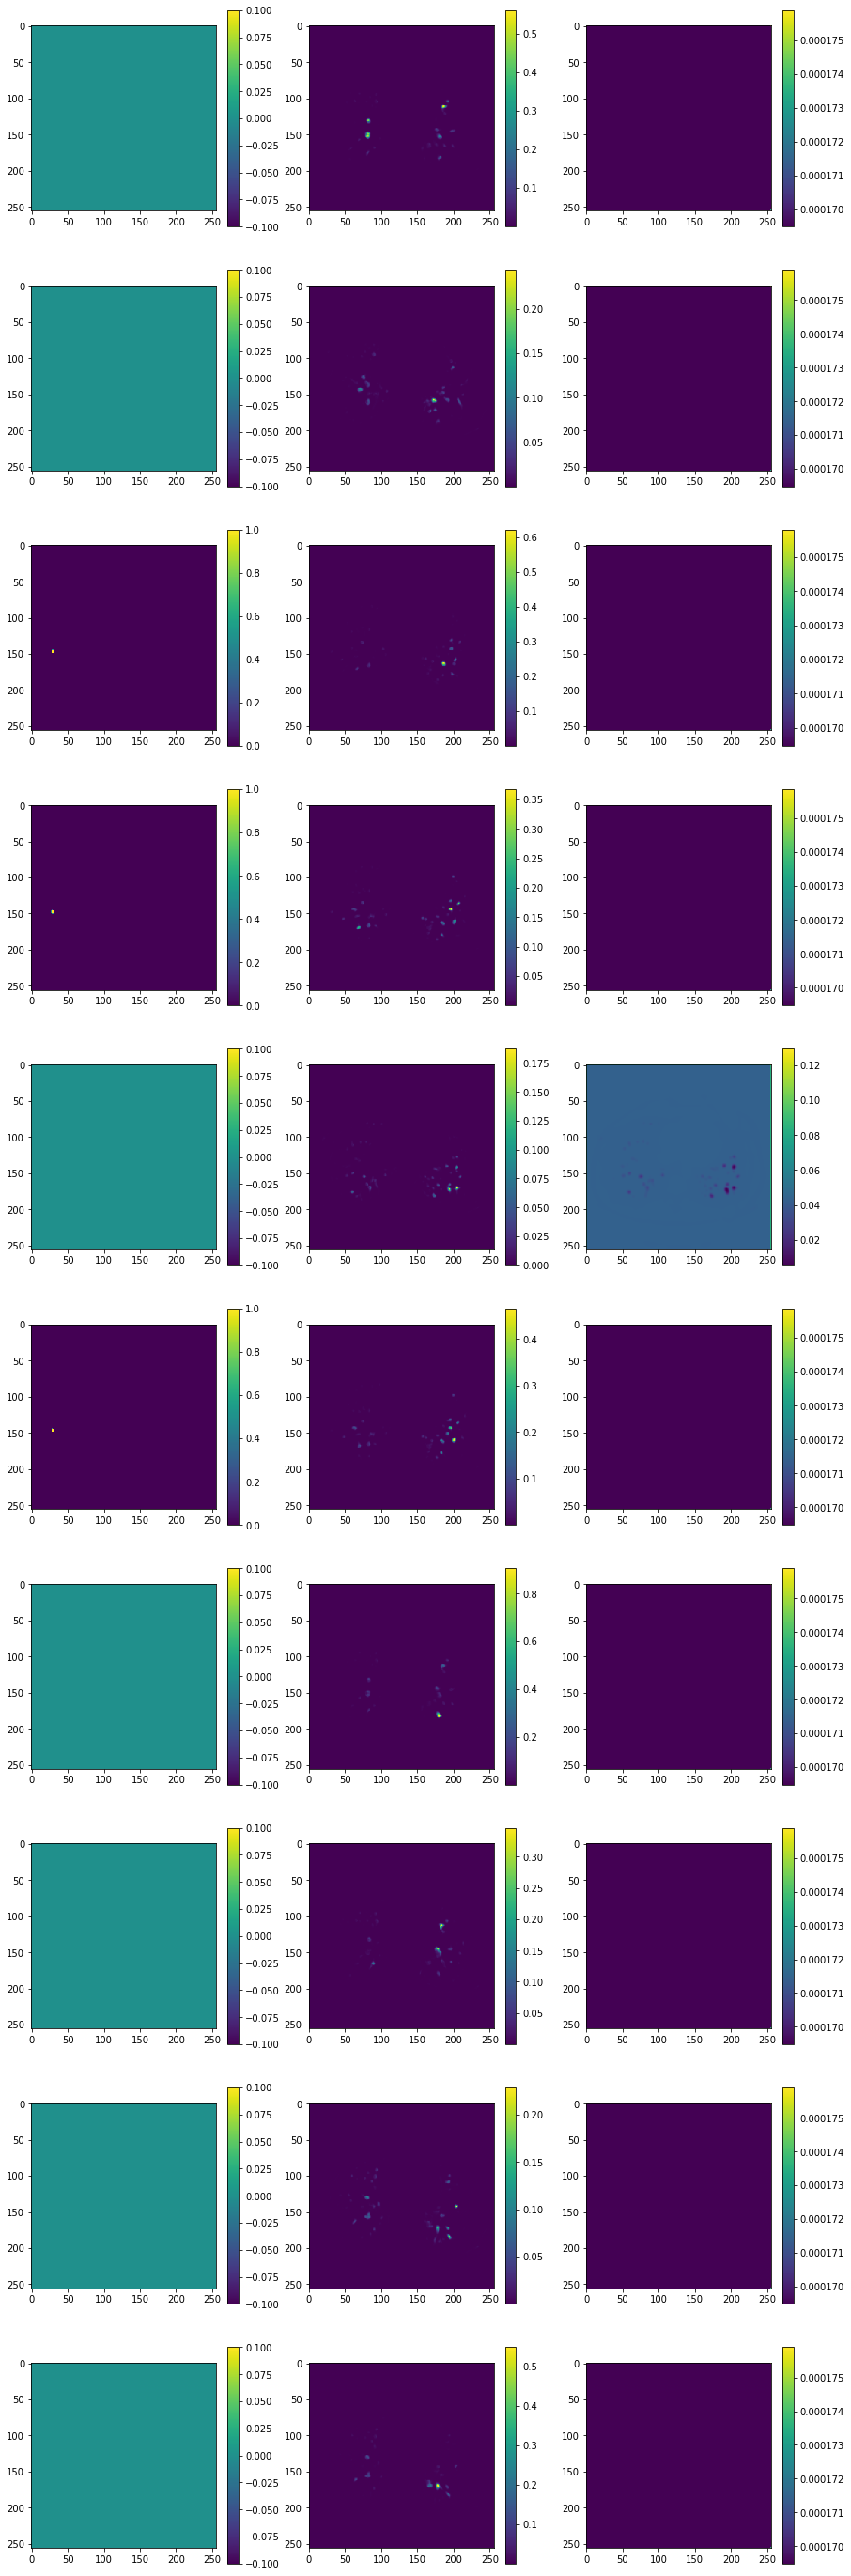

In [86]:
evaluate(617)

/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


AUC, precision, recall for patient num 77
Unet: 0.9372336085385232 0.0 0.0
LSTM: 0.6925835244159793 0.0 0.0
LSTM bw: 0.5596577202342266 0.0 0.0


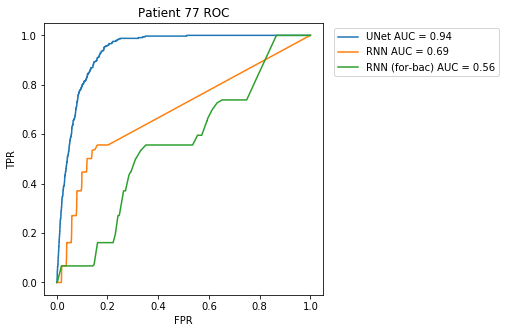

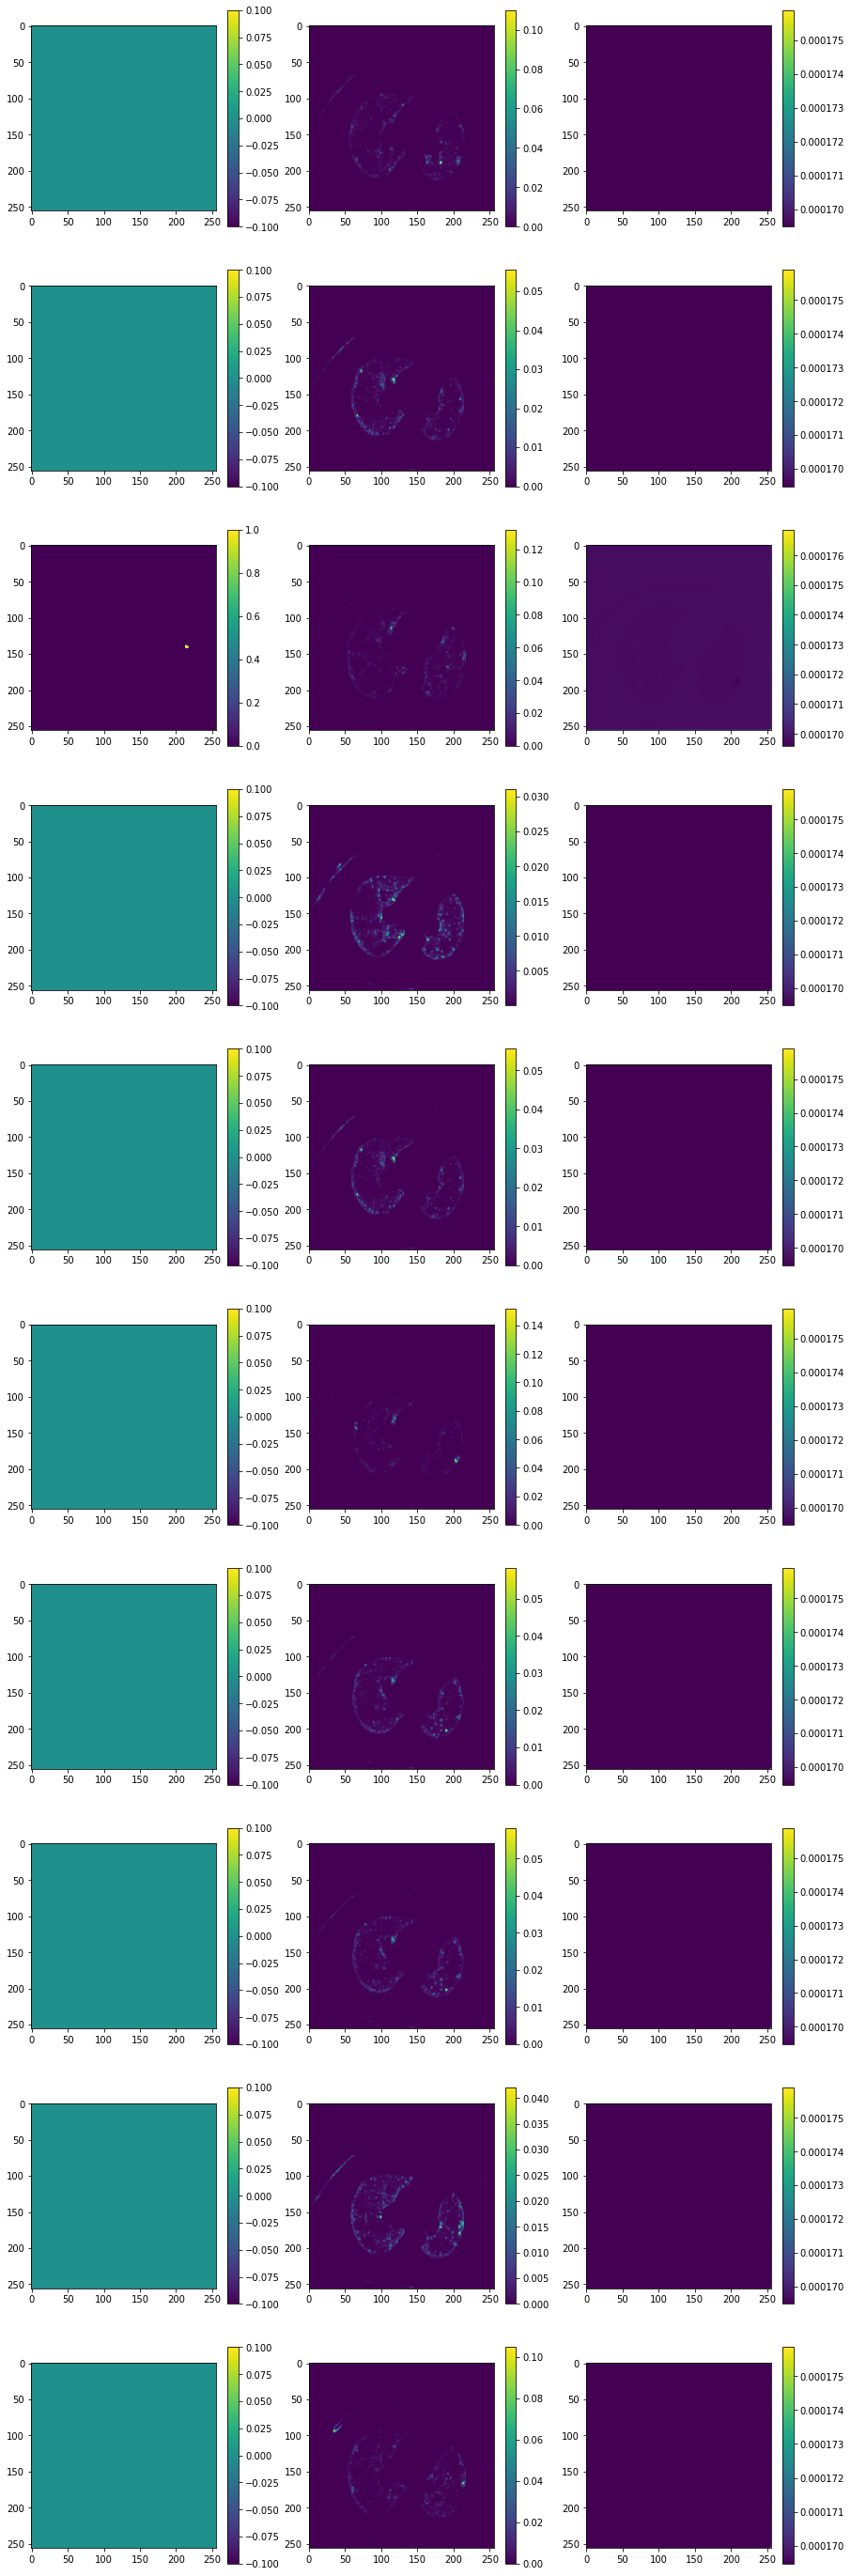

In [93]:
evaluate(77)

/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


AUC, precision, recall for patient num 110
Unet: 0.6725438907429895 0.0 0.0
LSTM: 0.39972494142186243 0.0 0.0
LSTM bw: 0.490219677748921 0.0 0.0


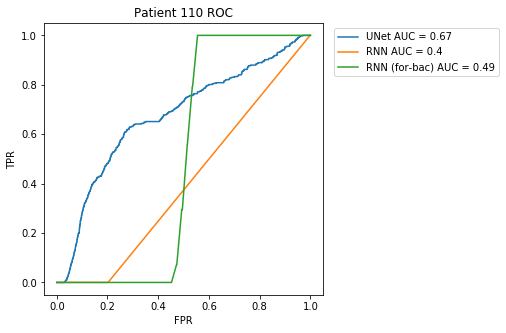

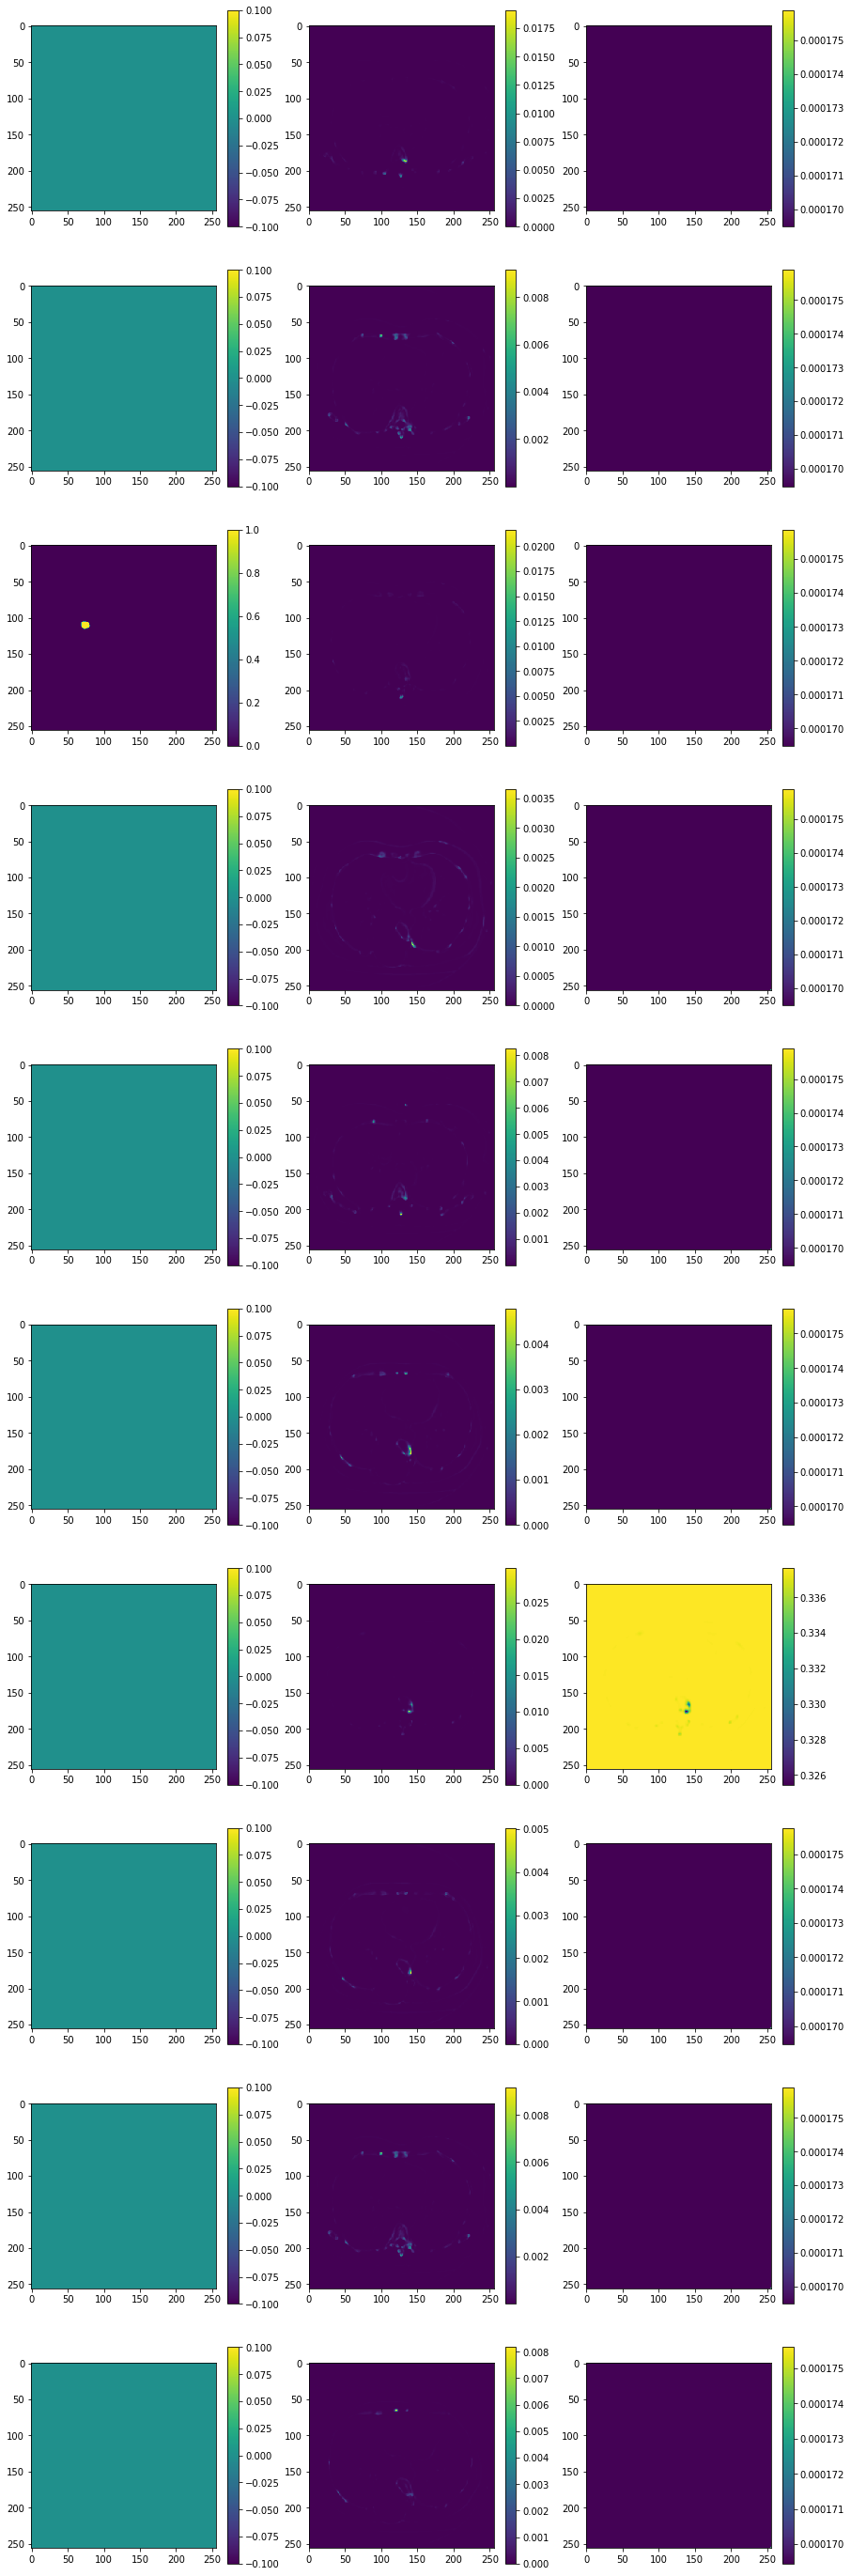

In [95]:
evaluate(110)

In [96]:
test

[77,
 34,
 88,
 271,
 265,
 449,
 342,
 110,
 31,
 448,
 124,
 97,
 920,
 24,
 245,
 904,
 267,
 626,
 717,
 572,
 807,
 402,
 732,
 282,
 617,
 900,
 465,
 870,
 117,
 488,
 590,
 733,
 430,
 613,
 95,
 847,
 524,
 366,
 213,
 37,
 140,
 826,
 352,
 926,
 143,
 325,
 953,
 1003,
 188,
 341,
 9,
 911,
 33,
 957,
 877,
 778,
 199,
 768,
 268,
 960,
 504,
 11,
 731,
 474,
 947,
 84,
 63,
 723,
 700,
 952,
 15,
 186,
 859,
 333,
 809,
 880,
 541,
 21,
 17,
 915,
 860,
 575,
 464,
 410,
 94,
 57,
 332,
 619,
 508,
 369,
 28,
 1007,
 326,
 607,
 593,
 503,
 726,
 609,
 751,
 365,
 355,
 871,
 690,
 334,
 153,
 543,
 862,
 112,
 12,
 839,
 979,
 629,
 718,
 135,
 602,
 770,
 711,
 566,
 479,
 314,
 789,
 813,
 498,
 776,
 653,
 122,
 673,
 885,
 888,
 418,
 35,
 721,
 1013,
 299,
 627,
 720,
 469,
 455,
 886,
 874,
 518,
 53,
 59,
 411,
 990,
 261,
 984,
 537,
 382,
 46,
 974,
 682,
 676,
 417,
 634,
 156,
 466,
 360,
 812,
 887,
 895,
 353,
 13,
 335,
 104,
 523,
 426,
 598,
 782,
 423,
 84

/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


AUC, precision, recall for patient num 402
Unet: 0.9977934502973946 0.0 0.0
LSTM: 0.3996998587031821 0.0 0.0
LSTM bw: 0.07780970095733937 0.0 0.0


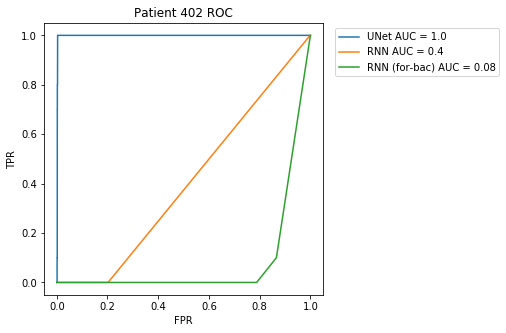

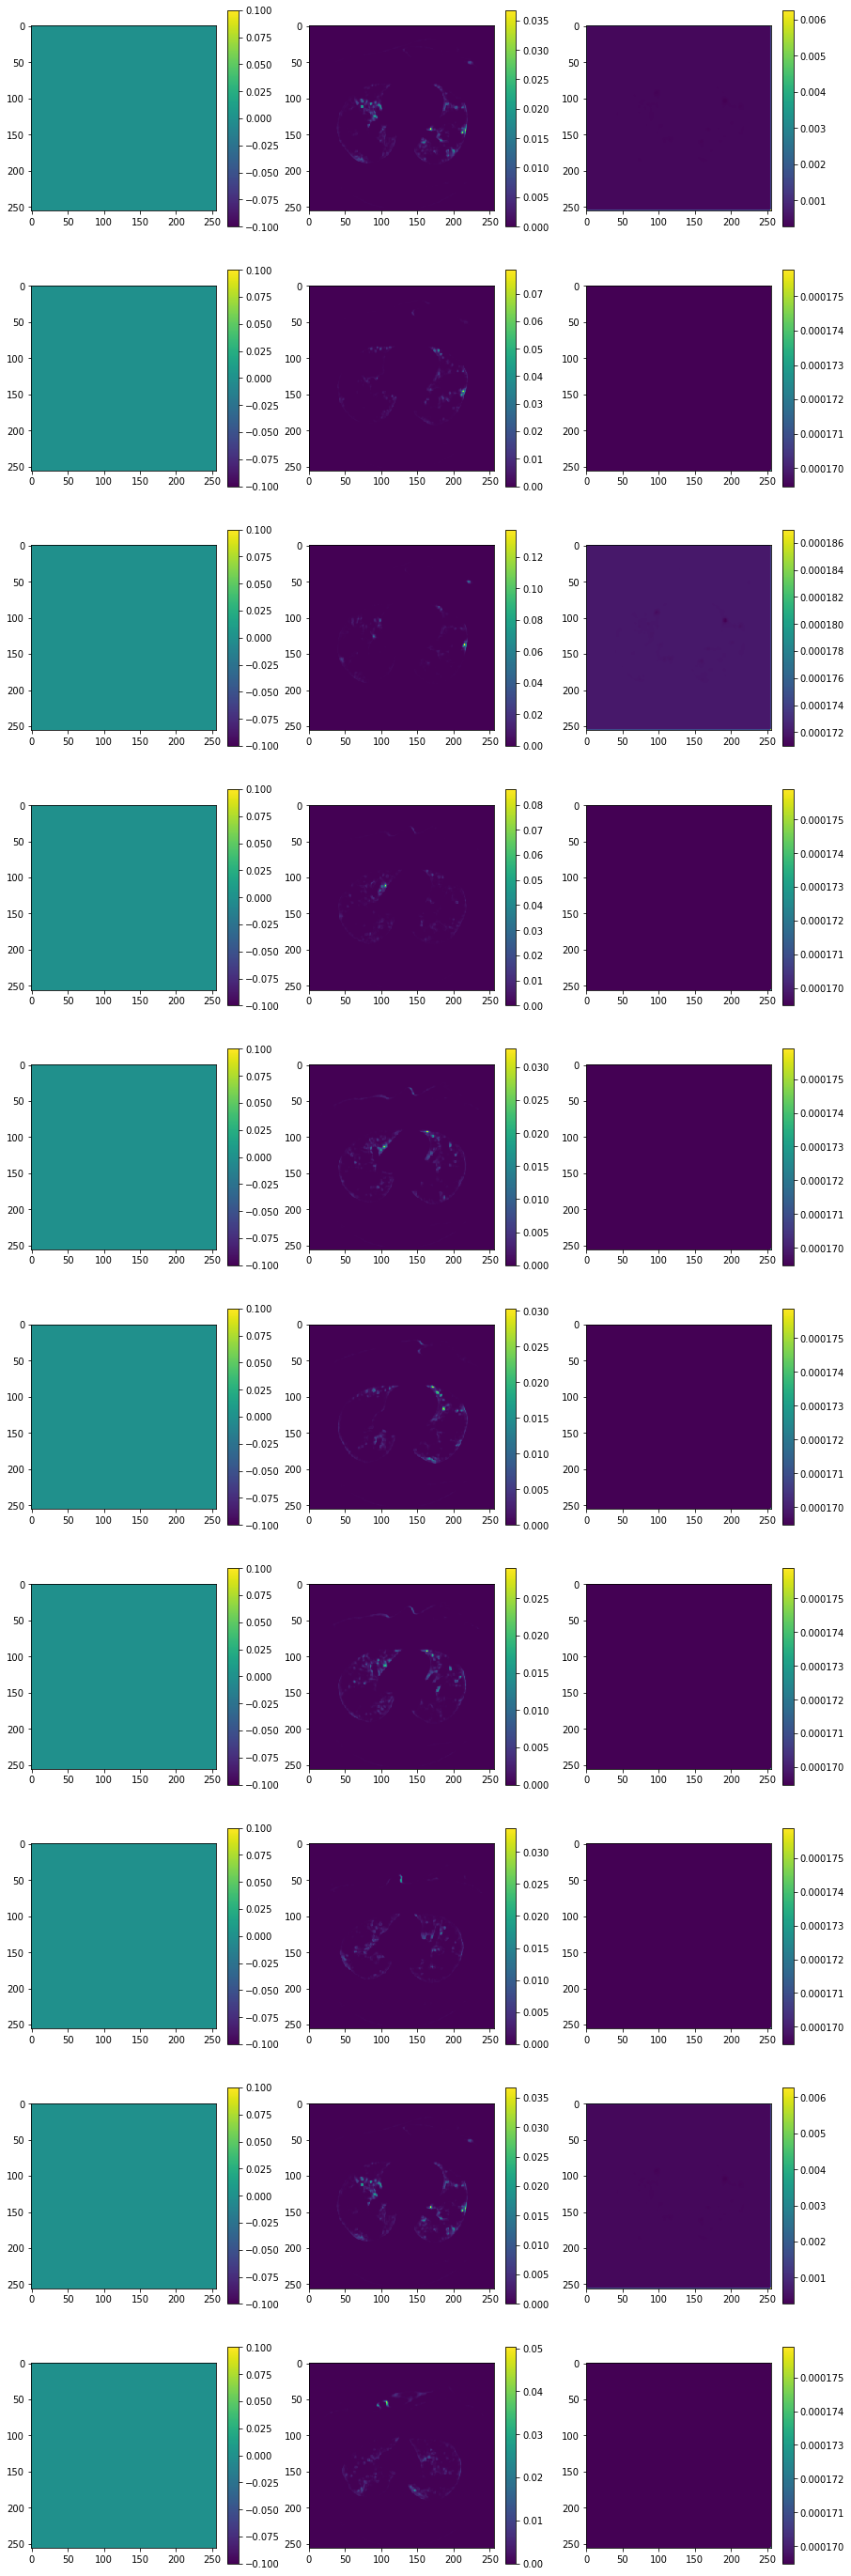

In [97]:
evaluate(402)